In [45]:
#Load Dataset
import struct
import numpy as np
import matplotlib.pyplot as plt

In [46]:
# ==========Load IDX Files ==========
def load_images(filename):
    with open(filename, 'rb') as f:
        _, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images=np.frombuffer(f.read(),
        dtype=np.uint8)
        images = images[:(len(images)//(rows * cols))
        * rows * cols]
    return images.reshape(-1, rows *
        cols).astype(np.float32) / 255.0

def load_labels(filename):
    with open(filename, 'rb') as f:
        _, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(),
        dtype=np.uint8)
    return labels[:num]

In [47]:
# ========== 1. Sigmoid Function ==========
def sigmoid(z):
    # TODO: Implement sigmoid function
    return 1 / (1 + np.exp(-z))

# ====== 2. Mini Batch SGD: Algorithm 7.2 ======
def sgd_minibatch(X, y, eta=0.01, max_iters=10000, batch_size=64):
    print("sgd_minibatch")
    print("Hyperparameters: eta = {}, max_iters = {}, batch_size = {}".format(eta, max_iters, batch_size))
    w = np.zeros(X.shape[1])
    N = X.shape[0]
    loss_history = []
    
    for i in range(max_iters):
        idx = np.random.permutation(N)
        X, y = X[idx], y[idx]

        for start in range(0, N, batch_size):
            end = start + batch_size
            X_batch, y_batch = X[start:end], y[start:end]

            gradient = -(X_batch.T @ (y_batch - sigmoid(X_batch @ w))) / batch_size
            w -= eta * gradient

        epoch_preds = sigmoid(X @ w)
        epoch_loss = -np.mean(y * np.log(epoch_preds + 1e-8) + (1 - y) * np.log(1 - epoch_preds + 1e-8))
        loss_history.append(epoch_loss)

    return w, loss_history

# ===== 3. Mini Batch SGD with Momentum: Algorithm 7.3 =====
def sgd_minibatch_momentum(X, y, eta=0.01, max_iters=10000, batch_size=64, momentum=0.9):
    print("sgd_minibatch_momentum")
    print("Hyperparameters: eta = {}, max_iters = {}, batch_size = {}, momentum = {}".format(eta, max_iters, batch_size, momentum))
    w = np.zeros(X.shape[1])
    delta_w = np.zeros(X.shape[1])
    N = X.shape[0]
    loss_history = []
    
    for i in range(max_iters):
        idx = np.random.permutation(N)
        X, y = X[idx], y[idx]

        for start in range(0, N, batch_size):
            end = start + batch_size
            X_batch, y_batch = X[start:end], y[start:end]
            gradient = -(X_batch.T @ (y_batch - sigmoid(X_batch @ w))) / batch_size
            delta_w = -eta * gradient + momentum * delta_w
            w += delta_w

        epoch_preds = sigmoid(X @ w)
        epoch_loss = -np.mean(y * np.log(epoch_preds + 1e-8) + (1 - y) * np.log(1 - epoch_preds + 1e-8))
        loss_history.append(epoch_loss)
        
    return w, loss_history

def sgd_minibatch_nesterov_momentum(X, y, eta=0.01, max_iters=10000, batch_size=64, momentum=0.9):
    print("sgd_minibatch_nesterov_momentum")
    print("Hyperparameters: eta = {}, max_iters = {}, batch_size = {}, momentum = {}".format(eta, max_iters, batch_size, momentum))
    w = np.zeros(X.shape[1])
    delta_w = np.zeros(X.shape[1])
    N = X.shape[0]
    loss_history = []
    for i in range(max_iters):
        idx = np.random.permutation(N)
        X, y = X[idx], y[idx]

        for start in range(0, N, batch_size):
            end = start + batch_size
            X_batch, y_batch = X[start:end], y[start:end]
            w_lookahead = w + momentum * delta_w
            gradient = -(X_batch.T @ (y_batch - sigmoid(X_batch @ w_lookahead))) / batch_size
            delta_w = momentum * delta_w - eta * gradient
            w += delta_w
            
        epoch_preds = sigmoid(X @ w)
        epoch_loss = -np.mean(y * np.log(epoch_preds + 1e-8) + (1 - y) * np.log(1 - epoch_preds + 1e-8))
        loss_history.append(epoch_loss)
        
    return w, loss_history

# ====== 4. Adam Optimizer: Algorithm 7.4 ======
def sgd_Adam(X, y, eta=0.001, max_iters=10000, batch_size=64, beta1=0.9, beta2=0.999, delta=1e-8):
    print("sgd_Adam")
    print("Hyperparameters: eta = {}, max_iters = {}, batch_size = {}, beta1 = {}, beta2 = {}".format(eta, max_iters, batch_size, beta1, beta2))
    w = np.zeros(X.shape[1])
    s = np.zeros(X.shape[1])
    r = np.zeros(X.shape[1])
    N = X.shape[0]
    loss_history = []
    
    for iteration in range(1, max_iters + 1):
        idx = np.random.permutation(N)
        X, y = X[idx], y[idx]

        for start in range(0, N, batch_size):
            end = start + batch_size
            X_batch, y_batch = X[start:end], y[start:end]

            g = -(X_batch.T @ (y_batch - sigmoid(X_batch @ w))) / batch_size
            s = beta1 * s + (1 - beta1) * g
            r = beta2 * r + (1 - beta2) * (g ** 2)

            s_corrected = s / (1 - beta1 ** iteration)
            r_corrected = r / (1 - beta2 ** iteration)

            w -= eta * s_corrected / (np.sqrt(r_corrected) + delta)
        epoch_preds = sigmoid(X @ w)
        epoch_loss = -np.mean(y * np.log(epoch_preds + 1e-8) + (1 - y) * np.log(1 - epoch_preds + 1e-8))
        loss_history.append(epoch_loss)
        
    return w, loss_history

In [48]:
# ==========Show Misclassified Samples ==========
def show_misclassified(X, true_labels, pred_labels, max_show=10):
    mis_idx = np.where(true_labels != pred_labels)[0][:max_show]
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(mis_idx):
        plt.subplot(1, len(mis_idx), i + 1)
        plt.imshow(X[idx, 1:].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f"T:{true_labels[idx]}\nP:{pred_labels[idx]}")
    plt.suptitle("Misclassified Samples")
    plt.show()

In [49]:
# ========== 3. Main ==========
def run(model, eta=0.01, max_iters=10, batch_size=64, momentum=0.9):
    # === Load Data ===
    X_train = load_images("data/train-images.idx3-ubyte___")
    y_train = load_labels("data/train-labels.idx1-ubyte___")
    X_test = load_images("data/t10k-images.idx3-ubyte___")
    y_test = load_labels("data/t10k-labels.idx1-ubyte___")

    # === Choose binary classification target digit ===
    TARGET_DIGIT = 3
    print(f"Binary Classification Target Digit: {TARGET_DIGIT}")

    y_train_bin = np.where(y_train == TARGET_DIGIT, 1, 0)
    y_test_bin = np.where(y_test == TARGET_DIGIT, 1, 0)

    # === Add bias term ===
    X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
    X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    # === Set parameters ===
    eta = eta # TODO: Learning rate
    max_iters = max_iters # TODO: Number of SGD iterations

    # === Train ===
    if model == sgd_minibatch:
        w, loss_history = model(X_train, y_train_bin, eta, max_iters, batch_size)
    elif model == sgd_minibatch_momentum or model == sgd_minibatch_nesterov_momentum:
        w, loss_history = model(X_train, y_train_bin, eta, max_iters, batch_size, momentum)
    elif model == sgd_Adam:
        w, loss_history = model(X_train, y_train_bin, eta, max_iters, batch_size)
    else:
        raise ValueError("Unknown model type provided.")
    
    # === Predict ===
    pred_probs = sigmoid(X_test @ w)
    preds = (pred_probs >= 0.5).astype(int)

    # === Evaluate ===
    accuracy = np.mean(preds == y_test_bin)
    print(f"Accuracy: {accuracy:.4f}")

    # === Show Misclassified Samples ===
    show_misclassified(X_test, y_test_bin, preds)
    
    # === Plot Training Curve ===
    plt.plot(range(1, max_iters + 1), loss_history, label='Training Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

Binary Classification Target Digit: 3
sgd_minibatch
Hyperparameters: eta = 0.01, max_iters = 20, batch_size = 64
Accuracy: 0.9746


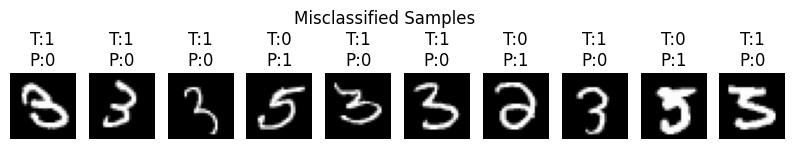

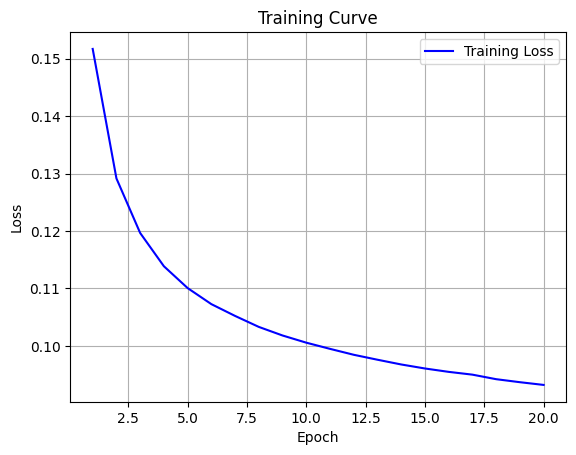

In [50]:
run(sgd_minibatch, eta=0.01, max_iters=20, batch_size=64)

Binary Classification Target Digit: 3
sgd_minibatch_momentum
Hyperparameters: eta = 0.01, max_iters = 20, batch_size = 64, momentum = 0.9
Accuracy: 0.9776


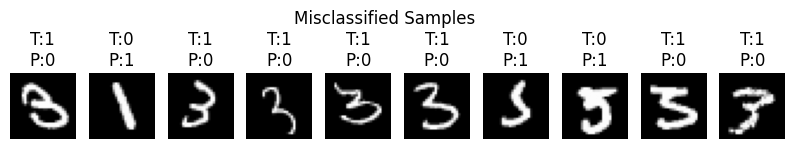

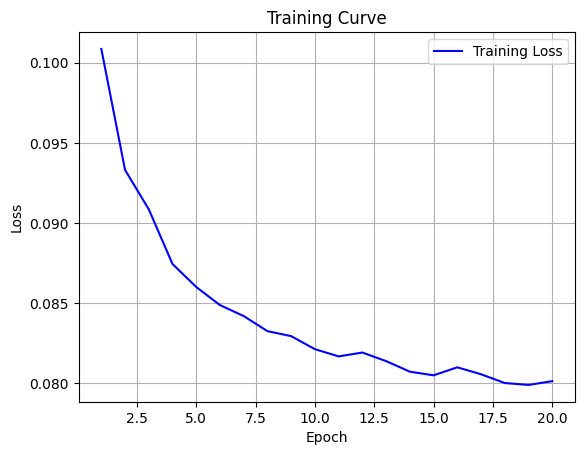

In [51]:
run(sgd_minibatch_momentum, eta=0.01, max_iters=20, batch_size=64, momentum=0.9)


Binary Classification Target Digit: 3
sgd_minibatch_nesterov_momentum
Hyperparameters: eta = 0.01, max_iters = 20, batch_size = 64, momentum = 0.9
Accuracy: 0.9782


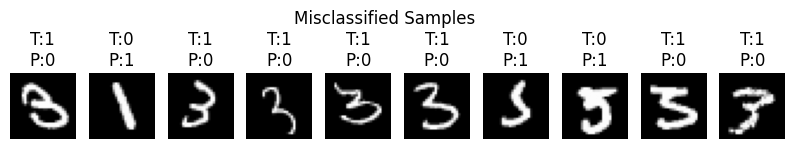

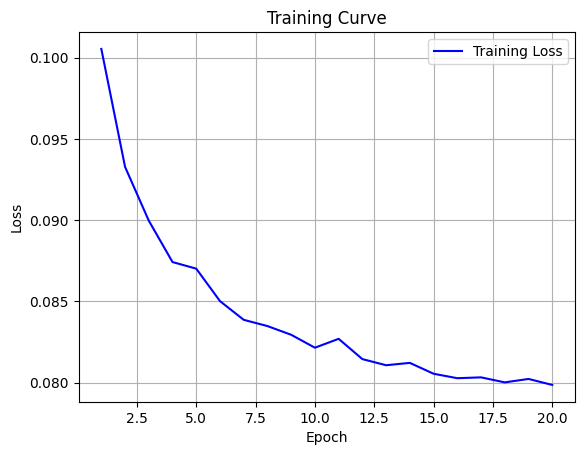

In [52]:
run(sgd_minibatch_nesterov_momentum, eta=0.01, max_iters=20, batch_size=64, momentum=0.9)


Binary Classification Target Digit: 3
sgd_Adam
Hyperparameters: eta = 0.001, max_iters = 20, batch_size = 64, beta1 = 0.9, beta2 = 0.999
Accuracy: 0.9766


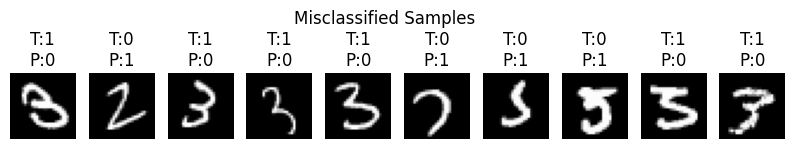

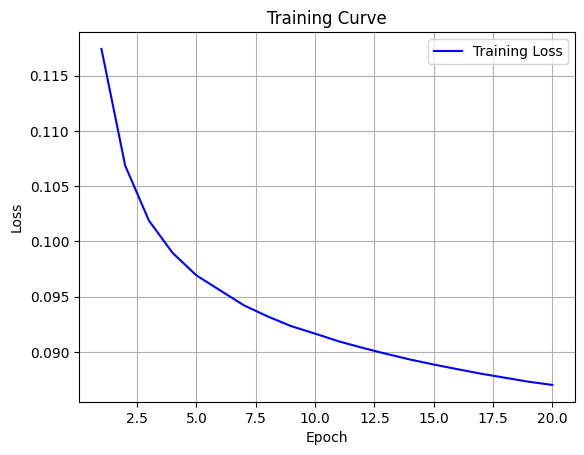

In [53]:
run(sgd_Adam, eta=0.001, max_iters=20, batch_size=64)

Binary Classification Target Digit: 3
sgd_Adam
Hyperparameters: eta = 0.01, max_iters = 20, batch_size = 64, beta1 = 0.9, beta2 = 0.999
Accuracy: 0.9785


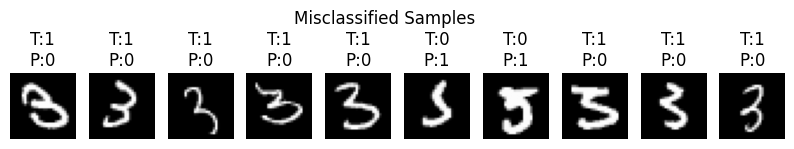

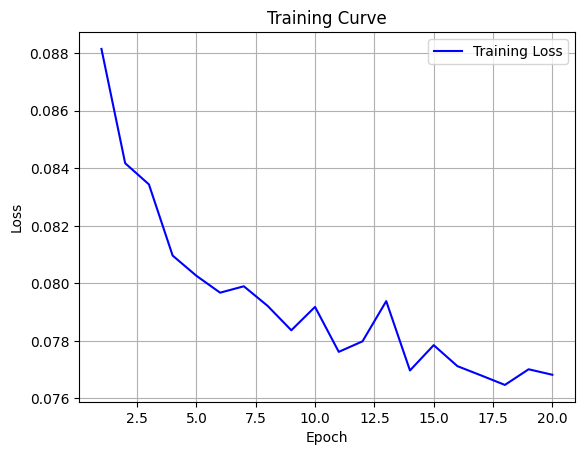

In [54]:
run(sgd_Adam, eta=0.01, max_iters=20, batch_size=64)

Binary Classification Target Digit: 3
sgd_Adam
Hyperparameters: eta = 0.01, max_iters = 20, batch_size = 128, beta1 = 0.9, beta2 = 0.999
Accuracy: 0.9788


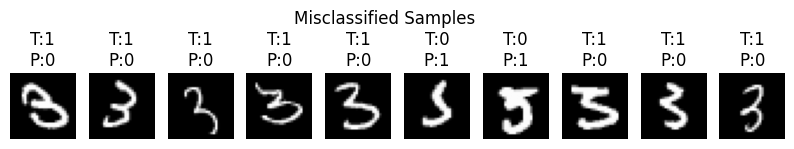

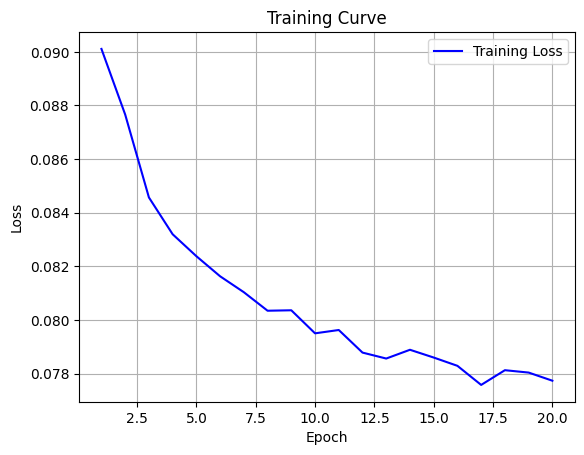

In [55]:
run(sgd_Adam, eta=0.01, max_iters=20, batch_size=128)